In [1]:
from lightning_script import LPRCharacterClassification
from pytorch_lightning import Trainer
from interfaces import LPRCharacterDataModule, LPRCharacter
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import wandb

import torchvision.transforms as TF
import random
from torchvision import datasets, transforms
import torch

2024-02-06 07:29:47.929792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
batch_size = 4
num_workers = 2
max_epoches = 200
is_fast_dev_run = False
is_wandb = True

lr = 1e-4
data_dir = 'dataset/MLPR_augmentedV15'
mean = [0.4333, 0.4317, 0.4317]
std = [0.2663, 0.2614, 0.2615]

## Data Visualization

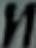

(None, tensor(27))

In [3]:
batch = LPRCharacter(data_dir='dataset/MLPR_augmentedV15', split='train')[random.randint(0, 10000)]
batch[0].show(), batch[1]

In [4]:
if is_wandb:
    wandb_logger = WandbLogger(project='LPR_Character_Classification', name=f'AWS_resnet18')
else:
    wandb_logger = None

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/sagemaker-user/.netrc


In [5]:
model = LPRCharacterClassification(lr=lr)
trainer = Trainer(fast_dev_run=is_fast_dev_run, max_epochs=max_epoches, logger=wandb_logger, log_every_n_steps=4, callbacks=[
                  EarlyStopping(monitor='val_loss', patience=10, mode='min')])
data_module = LPRCharacterDataModule(
    data_dir='dataset/MLPR_augmentedV15', batch_size=batch_size, numworkers=num_workers, mean=mean, std=std)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:

trainer.fit(model, data_module)
trainer.test(model, data_module)



  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 21.3 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.237    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7289130687713623     │
│         test_loss         │     0.79463130235672      │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.79463130235672, 'test_acc': 0.7289130687713623}]

In [7]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_loss,▇█▆▇▇▆▄▄▅▆█▅▆▇▂▂▆▃▅▄▄▃▃▃▃▂▄▃▄▃▃▂▂▂▂▃▃▁▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,0
test_acc,0.72891
test_loss,0.79463
train_loss,1.51022
trainer/global_step,403


# Sagemaker

In [12]:
import sagemaker
from sagemaker.pytorch import PyTorch
sagemaker_session = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [13]:
pytorch_estimator = PyTorch('train-sagemaker.py',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            framework_version='1.8.0',
                            py_version='py3',
                            role=,
                            hyperparameters = {'epochs': 20, 'batch-size': 64, 'learning-rate': 0.1})
pytorch_estimator.fit({'train': 's3://my-data-bucket/path/to/my/training/data',
                       'test': 's3://my-data-bucket/path/to/my/test/data'})

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


ValueError: An AWS IAM role is required to create an estimator.